In [1]:
# Load a model
from keras.models import load_model

model = load_model('sample_weights.hdf5')

Using TensorFlow backend.


In [2]:
# Load source samples:
import seaborn
import librosa
import numpy as np

audio_filename = './spooky2.wav'

sr = 8000
ally, _ = librosa.load(audio_filename, sr=sr, mono=True)
print(ally.shape)

(2951837,)


In [3]:
# Shorten sample for testing with laptop RAM to 10%:
ylen = len(ally) // 10
print(ylen)
y = ally[40000:40000+ylen]

print(y.shape)

min_y = np.min(y)
max_y = np.max(y)

# normalize
y = (y - min_y) / (max_y - min_y)
print(y.dtype, min_y, max_y)

from IPython.display import Audio
Audio(y, rate=sr)

295183
(295183,)
float32 -0.948366 0.899131


100%|██████████| 5000/5000 [01:52<00:00, 44.54it/s]


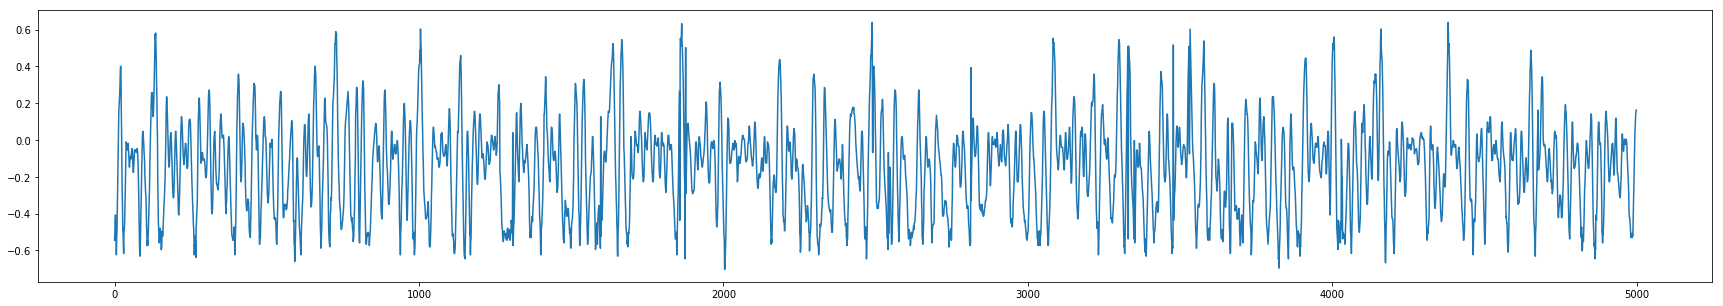

100%|██████████| 5000/5000 [01:53<00:00, 44.07it/s]


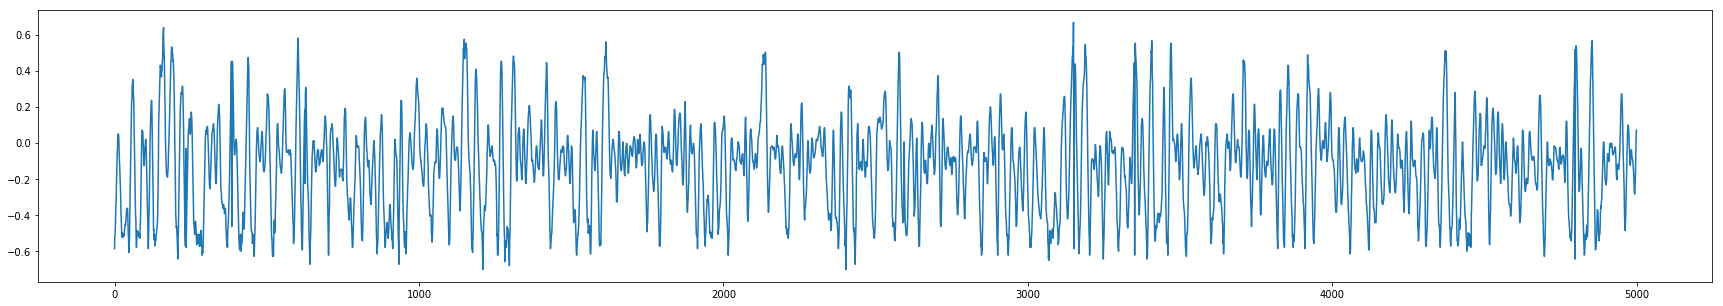

100%|██████████| 5000/5000 [01:54<00:00, 43.67it/s]


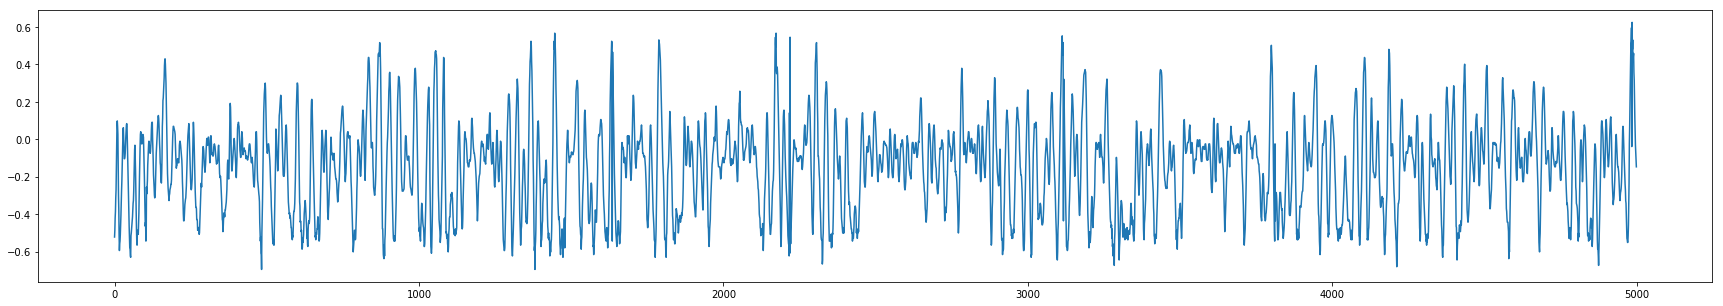

  7%|▋         | 358/5000 [00:08<01:44, 44.23it/s]

In [ ]:
from tqdm import tqdm
import matplotlib.pyplot as plt

# so try to estimate next sample afte given (maxlen) samples
maxlen     = 128 # 128 / sr = 0.016 sec
nb_output = 256  # resolution - 8bit encoding
latent_dim = 128 

def sample(preds, temperature=1.0, min_value=0, max_value=1):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    v = np.argmax(probas)/float(probas.shape[1])
    return v * (max_value - min_value) + min_value
     
for start in range(5000,220000,10000):
    seq = y[start: maxlen]  
    seq_matrix = np.zeros((maxlen, nb_output), dtype=bool) 
    for i,s in enumerate(seq):
        sample_ = int(s * (nb_output - 1)) # 0-255
        seq_matrix[i, sample_] = True

    for i in tqdm(range(5000)):
        z = model.predict(seq_matrix.reshape((1,maxlen,nb_output)))
        s = sample(z[0], 1.0)
        seq = np.append(seq, s)

        sample_ = int(s * (nb_output - 1))    
        seq_vec = np.zeros(nb_output, dtype=bool)
        seq_vec[sample_] = True

        seq_matrix = np.vstack((seq_matrix, seq_vec))  # added generated note info 
        seq_matrix = seq_matrix[1:]
        
    # scale back 
    seq = seq * (max_y - min_y) + min_y
    
    # plot
    plt.figure(figsize=(30,5))
    plt.plot(seq.transpose())
    plt.show()
    
    # Play
    display(Audio(seq, rate=sr))

In [ ]:
from IPython.display import Audio
Audio(y, rate=sr)